In [17]:
# from IPython import get_ipython
# get_ipython().magic('reset -sf')

import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import norm
from matplotlib import gridspec
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties as fp

# %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [18]:
# import the data
df = pd.read_excel("fragility_curve_database_pga.xlsx")

rc_mrf_m = df[df["Author"] == "Martins et al."]
rc_mrf_m2 = rc_mrf_m[rc_mrf_m.PGA_des > 0.5]

x = rc_mrf_m2.PGA_des   # independent variable
y = rc_mrf_m2.med_c_PGA   # dependent varaible
ym = np.mean(y) 


In [19]:
# Constants and functions for plotting
figure_folder = Path('C:/niccl/Documents/risiko-basierte-erdbebenkarte/Bearbeitung/figures')
colours = {1:'k', 2:'b', 3:'r', 4:'g', 5:'darkorange', 6:'c',
           7:'m', 8:'k', 9:'y', 10:'lawngreen'} 

axis_title_font = {'family': 'serif',
                    'color':  'black',
                    'weight': 'normal',
                    'size': 10,
                    }

annotation_font = fp(family='serif', style='normal', size=9,
                          weight='normal', stretch='normal')

axis_ticklabel_font = fp(family='serif', style='normal', size=9,
                          weight='normal', stretch='normal')

legend_font = fp(family='serif', style='normal', size=9,
                          weight='normal', stretch='normal')

file_type = "pdf"

# create a basic figure
def basic_1x1_figure():
    fig = plt.figure(figsize=(3.2, 3))
    gs = gridspec.GridSpec(1, 1, width_ratios=[1],
                       wspace=0.2, hspace=0.2, top=0.98, bottom=0.15, left=0.15, right=0.99)
    ax = fig.add_subplot(gs[0,0])
    return ax
    
# basic formating of the axes etc    
def basic_1x1_format_and_save(ax, figure_name):
    for label in ax.get_yticklabels() :
        label.set_fontproperties(axis_ticklabel_font)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(axis_ticklabel_font)

    ax.legend(prop=legend_font)
    ax.tick_params('both', direction='in', which='both', pad=6)
    ax.set_xlim(0)

    plt.savefig(figure_folder / figure_name, dpi=800)
    plt.savefig(figure_folder / (figure_name + "." + file_type), dpi=800, format=file_type)
    return

In [20]:
# linear function for fitting
def linear_fn(x, m, c):
    return m*x + c
    
# residuals from fit
def residuals(x, y, fn, params):
    return y - fn(x, *params)
    
# SST - sum of squares total
def sst(y_fit, y_mean):
    return np.sum((y_fit - y_mean) ** 2)
    
# SSE - sum of squares due to error
def sse(y_fit, y):
    return np.sum((y_fit - y) ** 2)
    
# SSR - sum of squares due to regression
def ssr(y, y_mean):
    return np.sum((y - y_mean) ** 2)
   
# pgas for plotting best fit    
PGAS = np.linspace(0.0, 5, num=51)


In [21]:
# mean values for each intensity level
unique_pgas = np.unique(rc_mrf_m2.PGA_des)
mean_capacities = np.array([np.mean(rc_mrf_m2[rc_mrf_m2.PGA_des == pga].med_c_PGA) for pga in unique_pgas])
print(mean_capacities)

[ 8.412075  20.576475  24.7805505 36.660951 ]


Text(0.5, 13.400000000000006, 'Design PGA [m/s²]')

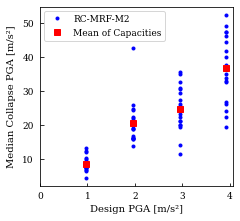

In [22]:
# Visualise the data
ax = basic_1x1_figure()
ax.plot(rc_mrf_m2.PGA_des, rc_mrf_m2.med_c_PGA, ".", color="b", label="RC-MRF-M2")
ax.plot(unique_pgas, mean_capacities, 's', color="r", label='Mean of Capacities')
basic_1x1_format_and_save(ax, "RC-MRF-M2_data")
ax.set_ylabel('Median Collapse PGA [m/s²]', fontdict=axis_title_font, labelpad=6)
ax.set_xlabel('Design PGA [m/s²]', fontdict=axis_title_font)

In [23]:
# Ordinary Least Squares Regression (OLS)
params, cov = curve_fit(linear_fn, x, y)

m_ols = params[0]
c_ols = params[1]

yf_ols = linear_fn(x, *params) 

sst_ols = sst(y, ym)
sse_ols = sse(y, yf_ols)
ssr_ols = ssr(yf_ols, ym)
ser_ols = np.sqrt(ssr_ols / (len(rc_mrf_m2.med_c_PGA) - 2)) # standard error of regression

r2 = 1 - (sse_ols / sst_ols)

r = residuals(x, y, linear_fn, params)
sigma_r = np.std(r)
error_sum = np.sum(r)

print(f"Ordinary Least-Squares:\n"
      f"{m_ols = }\n"
      f"{c_ols = }\n"
      f"{sst_ols = }\n"
      f"{sse_ols = }\n"
      f"{ssr_ols = }\n"
      f"{ser_ols = }\n"
      f"{r2 = }\n"
      f"{sigma_r = }\n")

Ordinary Least-Squares:
m_ols = 9.067350043748002
c_ols = 0.3698370502286821
sst_ols = 11477.514152849839
sse_ols = 3565.286499704929
ssr_ols = 7912.227729494487
ser_ols = 10.071683922999227
r2 = 0.689367710444541
sigma_r = 6.6757831934771215



In [24]:
# Regression through the origin (RTO)
m_rto = np.sum(x * y) / np.sum(x ** 2)
yf_rto = linear_fn(x, m_rto, 0)

sse_rto = sse(y, yf_rto)

r_rto = residuals(x, y, linear_fn, [m_rto, 0])
error_sum_rto = np.sum(r_rto)
sigma_r_rto = np.std(r_rto)

print(f"Regression through Origin:\n"
      f"{m_rto = }\n"
      f"{sse_rto = }\n"
      f"{error_sum_rto = }\n"
      f"{sigma_r_rto = }\n")

Regression through Origin:
m_rto = 9.193016666666667
sse_rto = 3567.1102251258467
error_sum_rto = 4.931160000000157
sigma_r_rto = 6.677205881662841



Text(0.5, 13.400000000000006, 'Desgin PGA, $a_{g,des}$ [m/s²]')

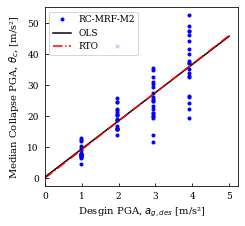

In [25]:
# Plotting Regressions
ax = basic_1x1_figure()
ax.plot(rc_mrf_m2.PGA_des, rc_mrf_m2.med_c_PGA, ".", color="b", label="RC-MRF-M2")
ax.plot(PGAS, linear_fn(PGAS,m_ols, c_ols), "-k", label="OLS")
ax.plot(PGAS, linear_fn(PGAS,m_rto, 0), "-.r", label="RTO")

basic_1x1_format_and_save(ax, "RC-MRF-M2_data")
ax.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=6)
ax.set_xlabel(r'Desgin PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)

In [26]:
# calculating plateau capacity
# plateau capacity is the mean of all the points <= 1 ms-2

residual_cap = np.mean(rc_mrf_m[rc_mrf_m.PGA_des <= 1.0].med_c_PGA)
pga_plateau = residual_cap / m_rto
print(residual_cap)
print(pga_plateau)

7.8426045
0.8531045666910209


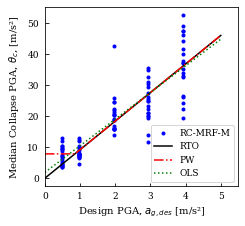

In [27]:
# plotting the two fit options
fit1_x = np.array([0, 5])
fit1_y = linear_fn(fit1_x, m_rto, 0)

fit2_x = np.array([0, pga_plateau, 5])
fit2_y = np.array([residual_cap, residual_cap, 5 * m_rto])

fit3_x = np.array([0, 5])
fit3_y = linear_fn(fit3_x, 8.579825433023016, 1.864480706359418)

ax = basic_1x1_figure()
ax.plot(rc_mrf_m.PGA_des, rc_mrf_m.med_c_PGA, ".", color="b", label="RC-MRF-M")
ax.plot(fit1_x, fit1_y, "-k", label=r"RTO")
ax.plot(fit2_x, fit2_y, "-.r", label="PW")
ax.plot(fit3_x, fit3_y, ":g", label="OLS")
ax.set_xlim(0,5.5)

ax.set_ylabel(r'Median Collapse PGA, $\theta_{c}$, [m/s²]', fontdict=axis_title_font, labelpad=6)
ax.set_xlabel(r'Design PGA, $a_{g,des}$ [m/s²]', fontdict=axis_title_font)
basic_1x1_format_and_save(ax, "Fig6_RC-MRF-M_piecewise")


Dispersion of median values: 0.27797255088714107


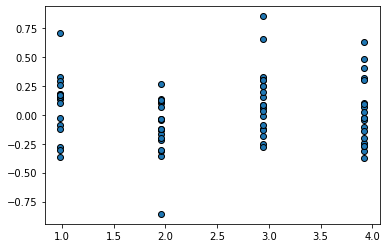

In [28]:
def dispersion(m, c, in_db):
    # finds the dispersion of the RV around the mean (best fit line)
    # Assumes lognormal and homoscedastic error
    err = [np.log(m*row["PGA_des"] + (c)) - np.log(row["med_c_PGA"]) for idx, row in in_db.iterrows()]
    n = len(err)
    plt.figure()
    plt.plot(in_db["PGA_des"], err, "o", mec="k")

    err = np.array(err)
    beta = np.sqrt((1 / (n-1)) * sum(err ** 2))
    print(f"Dispersion of median values: {beta}")
    
    return beta
    
rc_mrf_m_beta_theta = dispersion(m_rto, 0, rc_mrf_m2)